In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_theme()

In [4]:
dfo = pd.read_excel('data.xlsx')

In [5]:
filtered_s2k = [col for col in dfo.columns if 'S2K_item_' in col][:24]

filtered_columns = []

filtered_columns.append(dfo.SLET2T_ID.name)
filtered_columns.append(dfo.Visit_month_new.name)
filtered_columns.extend(filtered_s2k)
filtered_columns.append(dfo.New_SDI_since_previous_visit_new.name)

In [6]:
df = dfo[filtered_columns]

In [ ]:
df['New_SDI_since_previous_visit_new'].fillna(0, inplace=True)

In [8]:
ids = []
for id in df.SLET2T_ID.unique():
    if any(df[df.SLET2T_ID == id].New_SDI_since_previous_visit_new != 0):
        ids.append(id)


In [9]:
dfs = []

for id in ids:
    df_id = df[df.SLET2T_ID == id]
    
    first_occurrence = df_id[df_id.New_SDI_since_previous_visit_new == 1].index.min()
    
    if first_occurrence is not None:
        df_filtered = df_id.loc[:first_occurrence]
    else:
        df_filtered = df_id
    
    dfs.append(df_filtered)


In [10]:
max_shape = dfs[0].shape[0]
max_index = 0

for index, df in enumerate(dfs):
    if df.shape[0] > max_shape:
        max_shape = df.shape[0]
        max_index = index

print(f'Max shape: {max_shape}\nIndex: {max_index}')


Max shape: 12
Index: 13


In [11]:
padded_dfs = []

for df in dfs:
    num_rows_to_pad = 12 - df.shape[0]
    
    if num_rows_to_pad > 0:
        zero_df = pd.DataFrame(0, index=np.arange(num_rows_to_pad), columns=df.columns)
        
        padded_df = pd.concat([zero_df, df], ignore_index=True)
    else:
        padded_df = df
    
    padded_dfs.append(padded_df)


In [12]:
X = []

for df in padded_dfs:
    X.append(df.iloc[:, 2:-1])

X_train = np.array(X)


In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the dimensions of the input image
input_shape = (12, 24, 1)  # Example for a grayscale image of size 12x24

# Encoder
encoder_input = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Output: (6, 12, 32)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # Output: (3, 6, 64)
encoded = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = layers.UpSampling2D((2, 2))(encoded)  # Output: (6, 12, 128)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  # Output: (12, 24, 64)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Output: (12, 24, 1)

# Autoencoder model
autoencoder = models.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the model
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 24, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 12, 24, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 12, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 12, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 6, 12, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 12, 64)      │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 12, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 24, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 24, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,217 (723.50 KB)

 Trainable params: 185,217 (723.50 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = autoencoder.fit(X_train, X_train, epochs=50, validation_split=0.1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.2220 - val_loss: 0.0779
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0488 - val_loss: 0.0551
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0359 - val_loss: 0.0550
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0353 - val_loss: 0.0550
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0341 - val_loss: 0.0550
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0348 - val_loss: 0.0550
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0351 - val_loss: 0.0550
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0343 - val_loss: 0.0550
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0358 - val_loss: 0.0550
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0345 - val_loss: 0.0550
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0348 - val_loss: 0.0550
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0342 - val_loss: 0.0550
E

Text(0, 0.5, 'loss')

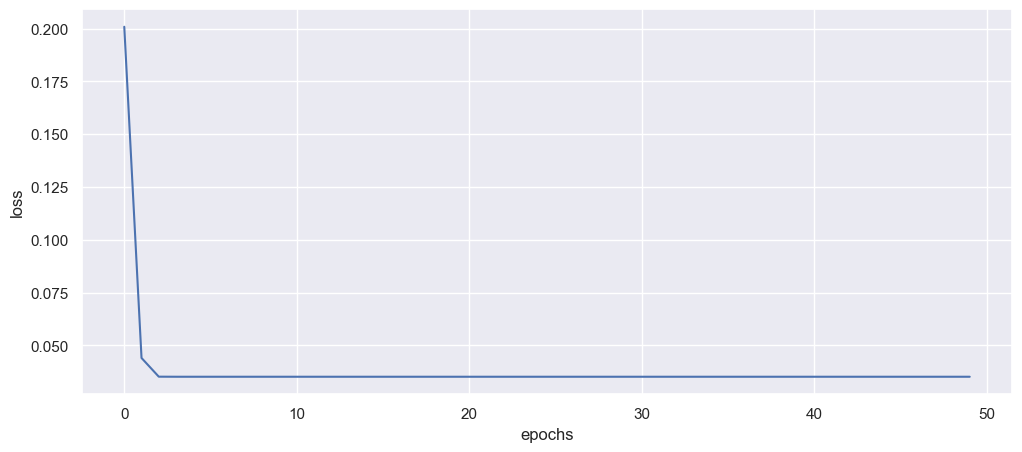

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

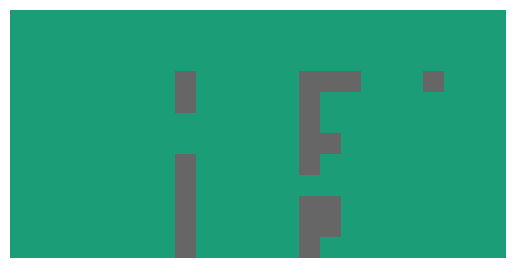

In [17]:
plt.imshow(X[5], cmap='Dark2')
plt.axis('off')
plt.show()
